## 3M Data Science Summer Internship 2023: Take-Home Assessment
##### Name: Guilherme de Sousa, PhD Candidate
##### Contact: gdesousa@umd.edu    https://guidesousa.com

### Summary of results:
1) 
2) 

### Assumptions & limitations:
- I considered the snow tubing service to happen when temperature < 32F & river tubing when temperature > 32F


### Future work:
- 

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

In [2]:
# Auxiliary functions
def normalize(df, cols=None):
    result = df.copy()
    if not cols:
        cols = df.columns
    for c in cols:
        mea_value = df[c].mean()
        std_value = df[c].std()
        result[c] = (df[c] - mea_value) / std_value
    return result

In [18]:
from os import listdir, getcwd

##############
# Load files #
##############
# PATH
PATH = getcwd() + '/data/'
files = listdir(PATH)

# Location, Holiday and Weather dataframes
df_loc = pd.read_csv(PATH+'location_data.csv')
df_hol = pd.read_csv(PATH+'holiday_data.csv')
df_wea = pd.read_csv(PATH+'weather_data.csv').astype({'date':'datetime64[ns]'})
df_wea['season'] = df_wea['temperature'].apply(lambda x: 'w' if x < 32 else 's')

# Transactions dataframe
df_tra = []
for file in files:
    if ('system1' in file):
        df_tra.append(pd.read_csv(PATH+file, index_col=None, header=0))
    if ('system2' in file):
        df_tra.append(pd.read_csv(PATH+file, index_col=None, header=0, sep='\t'))
    if ('system3' in file):
        with open(PATH + file) as f:
            data = json.loads(f.read())
            df_tra.append(pd.json_normalize(data))
df_tra = pd.concat(df_tra)
# Remove $ symbol in System 1
df_tra['profit'] = df_tra['profit'].apply(lambda x: str(x).split('$')[1] if '$' in str(x) else x)
# Fix negative values of System 2 that writes '0-x' for negative values
df_tra['profit'] = df_tra['profit'].apply(lambda x: '-'+str(x).split('-')[1] if '-' in str(x) else x)
# Change column datatypes for a standard format
df_tra = df_tra.astype({'location_id':int, 'date':'datetime64[ns]', 'transaction_id':int, 'profit':float})

# Dataframe for daily profit + location information
# Map 'cloudy' and 'precipitation' boolean into 0/1
# DropNA() for use in the modelling
df_pro = df_tra.groupby([df_tra['location_id'],df_tra['date']])[['profit']].agg('sum')
df_pro = pd.merge(df_pro, df_wea, how='left', left_on=['location_id','date'], right_on=['location_id','date'])
df_pro = pd.merge(df_pro, df_loc, how='left', left_on=['location_id'], right_on=['location_id'])
df_pro['cloudy'] = df_pro['cloudy'].replace({True: 1, False: 0})
df_pro['precipitation'] = df_pro['precipitation'].replace({True: 1, False: 0})
df_pro = df_pro.dropna()

# Normalized dataframe & remove NaN
df_nor = normalize(df_pro, ['profit', 'temperature', 'pressure', 'humidity', 'population', 'elevation'])
df_nor = df_nor.dropna()

# Sample values
df_pro.sample(10)

,location_id,date,profit,temperature,pressure,humidity,cloudy,precipitation,season,population,elevation
4828,7,2020-01-29,395.44,15.44,1047.769953,1.00,1.0,0.0,w,13400,186
3021,4,2022-08-27,437.47,69.44,974.624413,0.88,1.0,0.0,s,14255,360
5551,8,2019-12-10,332.95,16.34,985.105634,0.29,0.0,0.0,w,52185,398
506,1,2021-07-20,329.47,79.70,1016.103286,0.61,0.0,0.0,s,18428,375
4292,6,2021-06-18,246.64,57.02,1002.723005,0.82,0.0,0.0,s,86372,435
6071,8,2022-07-07,458.57,80.06,999.600939,0.64,0.0,0.0,s,52185,398
2629,4,2020-08-27,219.15,76.46,980.422535,0.99,0.0,0.0,s,14255,360
2305,4,2019-01-26,394.34,10.76,1038.626761,0.00,0.0,0.0,w,14255,360
2030,3,2021-07-18,460.58,71.24,980.422535,0.55,0.0,0.0,s,74138,505
540,1,2021-08-23,322.80,73.04,1035.950704,1.00,0.0,0.0,s,18428,375


Text(0.5, 1.0, 'Profit correlation')

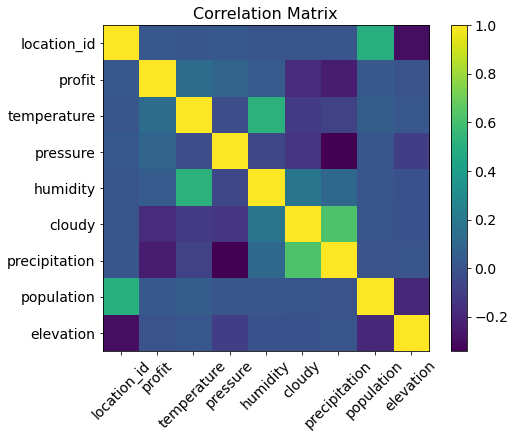

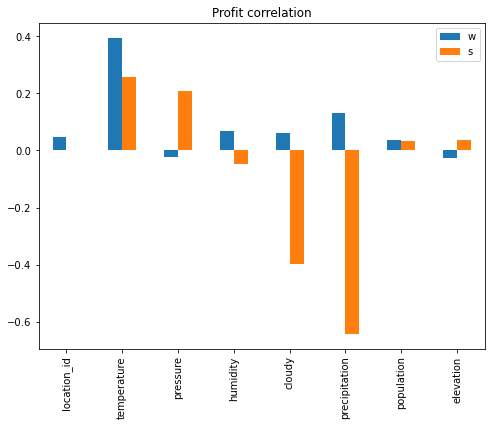

In [19]:
# Correlation Matrix for normalized daily profit dataframe
fig = plt.figure(figsize=(8, 6))
#plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
#plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
plt.imshow(df_nor.corr())
plt.xticks(range(df_nor.select_dtypes(['number']).shape[1]), df_nor.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_nor.select_dtypes(['number']).shape[1]), df_nor.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

# Profit correlation to the other variables
df_cor = pd.DataFrame()
for season in ['w', 's']:
    df_cor[season] = df_pro[df_nor['season']==season].corr()['profit'].drop('profit')
df_cor.plot.bar(figsize=(8, 6))
#df_nor[df_nor['season']=='s'].corr()['profit'].drop('profit').plot.bar()
plt.title('Profit correlation')

In [17]:
df_pro

,location_id,date,profit,temperature,pressure,humidity,cloudy,precipitation,season,population,elevation
0,1,2019-01-02,430.96,16.88,1034.166667,0.44,0.0,0.0,w,18428,375
1,1,2019-01-03,416.90,17.24,1015.657277,0.58,0.0,0.0,w,18428,375
2,1,2019-01-04,280.16,9.32,1028.145540,0.00,1.0,0.0,w,18428,375
3,1,2019-01-05,415.98,20.12,1035.950704,0.87,1.0,0.0,w,18428,375
4,1,2019-01-06,412.20,17.24,981.091549,0.80,0.0,0.0,w,18428,375
...,...,...,...,...,...,...,...,...,...,...,...
7637,10,2022-09-07,432.25,65.30,1046.431925,0.93,0.0,0.0,s,425336,266
7638,10,2022-09-08,405.04,NaN,NaN,NaN,NaN,NaN,NaN,425336,266
7639,10,2022-09-09,124.59,57.74,969.941315,0.97,1.0,1.0,s,425336,266
7640,10,2022-09-10,374.87,61.70,972.171362,0.83,0.0,0.0,s,425336,266


In [11]:
df_cor = pd.DataFrame()
for season in ['w', 's']:
    df_cor[season] = df_nor[df_nor['season']==season].corr()['profit'].drop('profit')

df_cor

,w,s
location_id,0.046247,0.001907
temperature,0.394807,0.258432
pressure,-0.022029,0.209279
humidity,0.067138,-0.049126
cloudy,0.059705,-0.396837
precipitation,0.131977,-0.642783
population,0.035714,0.034337
elevation,-0.027720,0.035329


In [230]:
# PCA - Principal Component Analysis
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_nor)

TypeError: invalid type promotion

In [239]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Train-Test data
x = df_nor[['temperature', 'pressure', 'humidity', 'cloudy', 'precipitation', 'population', 'elevation']].to_numpy()
y = df_nor['profit'].to_numpy()
y = y.reshape(-1, 1)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(xtrain, ytrain)
ypred = model.predict(xtest)
data = pd.DataFrame(data={"Predicted Profit": ypred.flatten()})
print(data.head())

   Predicted Profit
0          0.186390
1         -0.465613
2         -0.302902
3          0.359378
4         -0.443567


In [240]:
model.coef_

array([[ 0.10642254,  0.02900979,  0.02250026, -0.10060035, -0.44169811,
         0.03248465,  0.01412959]])

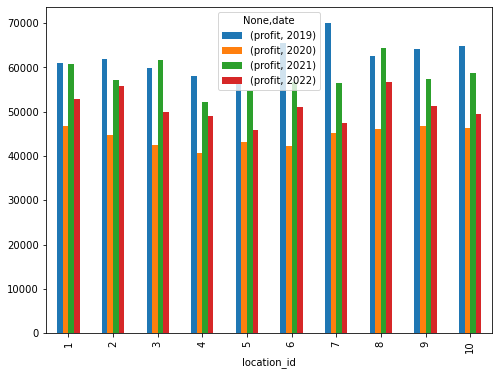

In [131]:
# Profit of each location for each year
df_yea = df_tra.groupby([df_tra['location_id'],df_tra['date'].dt.year])[['profit']].agg('sum')
df_yea.unstack('date').plot.bar(figsize=(8,6))

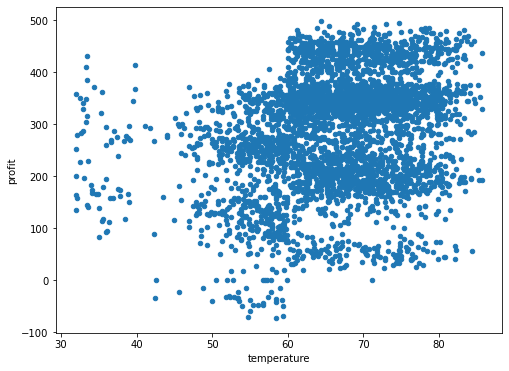

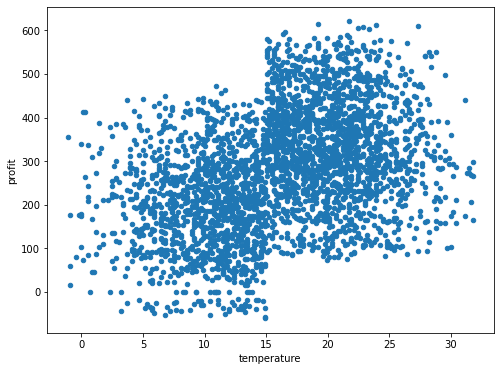

In [23]:
# Total profit for each day for all locations
#col = df_pro['location_id'].map({i:f'C{i}' for i in range(11)})
df_pro[df_pro['season']=='s'].plot.scatter(x='temperature', y='profit', figsize=(8,6))
df_pro[df_pro['season']=='w'].plot.scatter(x='temperature', y='profit', figsize=(8,6))